In [1]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FS = 44100 #sampling frequency

In [3]:
def create_t(length_seconds):
    return np.linspace(0, length_seconds, int(FS*length_seconds))

In [4]:
bitT = 0.01

In [17]:
S0 = np.sin(create_t(bitT)*2*np.pi* 1300)
S1 = np.sin(create_t(bitT)*2*np.pi*1700)

In [18]:
synT = create_t(bitT*10)
synS = np.cos(synT*2*np.pi*1500)

In [19]:
#sd.play(synS, FS)

In [20]:
get_pulse = {'0':S0, '1':S1}

In [21]:
STR = "Hello, world"

In [22]:
def str2bits(str):
    res = bin(int.from_bytes(str.encode('ascii'), 'big'))[2:]
    return '0'*(8 - (len(res) % 8)) + res

In [23]:
r = str2bits(STR)

In [24]:
r

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [25]:
def send(binstream):
    SigLen = S0.size
    n = len(binstream)
    S = np.empty(n*SigLen + synS.size)
    c = 0
    S[:synS.size] = synS
    for b in binstream:
        S[c*SigLen + synS.size:(c+1)*SigLen + synS.size] = get_pulse[b]
        c+=1 
    return S

In [26]:
W = send(r)

In [24]:
#sd.play(W, FS)

In [33]:
help(W)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

In [27]:
def decode(W):
    corr = np.correlate(W, synS, 'valid')
    start_syn = np.argmax(corr)
    start = start_syn + synS.size
    result = ''
    rlen = int((W.size)/(bitT*FS))
    for i in range(len(STR)*8):
        symStart = start + int(i*bitT*FS)
        symEnd = symStart + int(bitT*FS)
        S0max = np.max(np.correlate(W[symStart:symEnd], S0[:S0.size//2]))
        S1max = np.max(np.correlate(W[symStart:symEnd], S1[:S1.size//2]))
        result += '0' if S0max > S1max else '1'
    return result

In [28]:
decode(np.hstack((np.random.normal(0, 1, 1050), W, np.random.normal(0,1, 1000))))

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [29]:
r

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [30]:
r == decode(W)

True

In [31]:
%%time
decode(W)

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 55.5 ms


'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [ ]:
sigma = 1
Wnoise = W + np.random.normal(0, sigma, W.size)
decode(Wnoise) == r

In [ ]:
#generate colored white noise
from scipy.fftpack import rfft, irfft, fftfreq

def bandpass_noise(sigma_pass, sigma_out):
    white_noise = np.random.normal(0, 1, W.size)

    freq = fftfreq(white_noise.size, d = 1/FS)
    f_wnoise = rfft(white_noise)

    # If our original signal time was in seconds, this is now in Hz
    in_band_mask = np.logical_or(np.logical_and(freq < 2000, freq > 1000), np.logical_and(freq > -2000,freq < -1000))
    out_of_band_mask = np.logical_not(in_band_mask)
    f_wnoise[out_of_band_mask] *= sigma_out
    f_wnoise[in_band_mask] *= sigma_pass
    return irfft(f_wnoise)

In [ ]:
col_noise = bandpass_noise(1, 100)

In [ ]:
decode(0.1*(W + bandpass_noise(3, 3))) == r

In [ ]:
#sd.play(0.05*(W + bandpass_noise(3, 3)))

In [1]:
x_freq, fft = fftfreq(W.size, d = 1/FS), rfft(W)

NameError: name 'fftfreq' is not defined

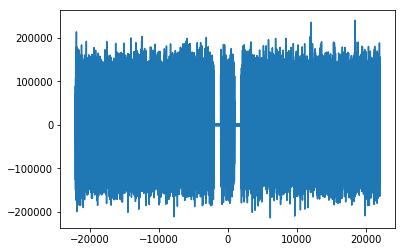

In [214]:
plt.plot(fftfreq(W.size, d = 1/FS), rfft(col_noise))

In [215]:
sd.play(W*0.1 + bandpass_noise(0.1, 2), FS)

-1.0

In [239]:
sd.play(np.hstack((np.zeros((22000,)), W)), FS)

In [218]:
rec = sd.rec(blocking=False)

10.6